In [1]:
import os
import time
import glob
import itertools
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.externals import joblib
from sklearn.pipeline import Pipeline
from scipy.ndimage.measurements import label

from vehicle_training import *

%matplotlib inline

In [2]:
## Set HOG Parameters

color_space = 'YUV' # Can be RGB, HSV, HLS, or YUV
orient = 9  # HOG orientations
pix_per_cell = 10 # HOG pixels per cell
cell_per_block = 3 # HOG cells per block
hog_channel = 0 # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

## Import Vehicle and Non-Vehicle Images
## Extract features from Vehicle and Non-Vehicle images

print('Importing images and extracting HOG features ...')
vehicles = glob.iglob('data/vehicles/**/*.png')
vehicle_features = extract_features(vehicles, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

non_vehicles = glob.iglob('data/non-vehicles/**/*.png')
non_vehicle_features = extract_features(non_vehicles, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

print('Feature extraction complete.')

Importing images and extracting HOG features ...
Feature extraction complete.


In [3]:
## Create an array stack of feature vectors
X = np.vstack((vehicle_features, non_vehicle_features)).astype(np.float64)                        

## Define the labels vector
y = np.hstack((np.ones(len(vehicle_features)), np.zeros(len(non_vehicle_features))))

In [4]:
## Split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

In [5]:
## Train with SVC using HOG features

print('Training with SVC ...')

clf = Pipeline([('scaling', StandardScaler()), ('classification', LinearSVC(loss='hinge')),])

## Check the training time for the SVC
t1=time.time()
clf.fit(X_train, y_train)
t2 = time.time()

print('SVC training finished.')
print(round(t2-t1, 1), 'seconds to train SVC.')

Training with SVC ...
SVC training finished.
7.6 seconds to train SVC.


In [6]:
## Check the accuracy of the SVC classifier
print('Test Accuracy of classifier = ', round(clf.score(X_test, y_test), 4))
## Check the prediction time for n samples
t1=time.time()
n_predict = 10
print('My classifier predicts: ', clf.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t1, 4), 'seconds to predict', n_predict,'labels')

Test Accuracy of classifier =  0.9856
My classifier predicts:  [ 0.  0.  1.  1.  1.  1.  1.  1.  1.  0.]
For these 10 labels:  [ 0.  0.  1.  1.  1.  1.  1.  1.  1.  0.]
0.0 seconds to predict 10 labels


In [7]:
## Save SVC model
from sklearn.externals import joblib
config = dict(color_space=color_space, 
            spatial_size=spatial_size, hist_bins=hist_bins, 
            orient=orient, pix_per_cell=pix_per_cell, 
            cell_per_block=cell_per_block, 
            hog_channel=hog_channel, spatial_feat=spatial_feat, 
            hist_feat=hist_feat, hog_feat=hog_feat)
joblib.dump({'model':clf, 'config':config}, 'models/clf_9_10_3_0.pkl')

['models/clf_9_10_3_0.pkl']

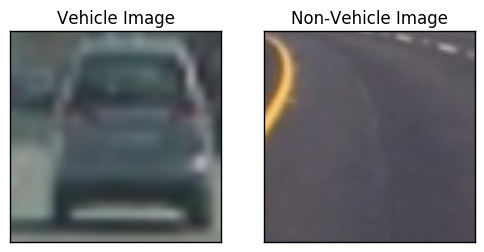

In [8]:
## Display example images of vehicles and non-vehicles
vehicles = glob.glob('data/vehicles/**/*.png')
non_vehicles = glob.glob('data/non-vehicles/**/*.png')
vehicle = mpimg.imread(vehicles[7])
non_vehicle = mpimg.imread(non_vehicles[7])

plt.subplot(1,2,1)
plt.title('Vehicle Image')
plt.imshow(vehicle)
plt.xticks([])
plt.yticks([])

plt.subplot(1,2,2)
plt.imshow(non_vehicle)
plt.title('Non-Vehicle Image')
plt.xticks([])
plt.yticks([])
plt.show()


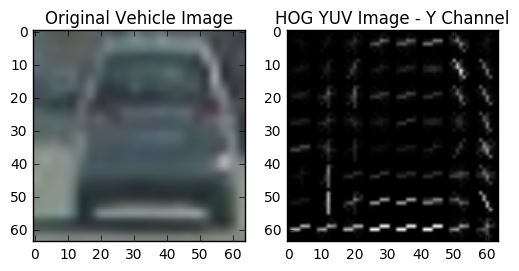

In [9]:
## Display an original image and HOG features image
img = (vehicle*255).astype(np.uint8)
from skimage.feature import hog
from skimage import data, color, exposure

hog_feat, hog_image = hog(img[:,:,0], orientations=orient, pixels_per_cell=(8, 8),
                    cells_per_block=(2, 2), visualise=True)

hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 0.02))

plt.subplot(1,2,1)
plt.title('Original Vehicle Image')
plt.imshow(img)

plt.subplot(1,2,2)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG YUV Image - Y Channel')
plt.show()

73


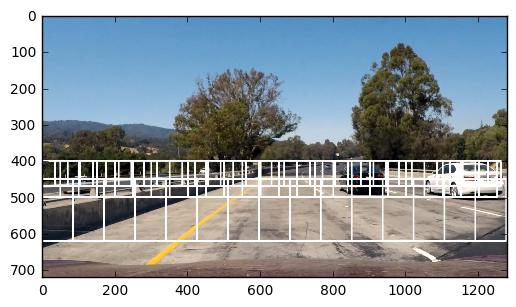

In [12]:
## Display example image with Sliding Window Search locations 
from vehicle_detection import window_search
image = mpimg.imread('test_images/test1.jpg')
pyramid = [((70, 70), [400, 500]),
           ((100, 100), [400, 500]),
           ((170, 170), [450, 620]),
              ]
image_size = image.shape[:2]
windows = window_search(pyramid, image_size)
print(len(list(itertools.chain(*windows))))
for p1, p2 in itertools.chain(*windows):
    cv2.rectangle(image, p1, p2, (255,255,255), 3)
plt.imshow(image)
plt.show()